# Lab 3
Danila Danko, Andrey Linyushin

## 1. Motor simulation

### 1.1

In [1]:
import numpy as np
from scipy.integrate import solve_ivp

In [36]:
milli = 10 ** (-3)
kilo = 10 ** 3
centi = 10 ** (-2)
rps = 2*np.pi/60
mdata = {
    "nominal voltage, V": 12,
    "no load speed, rpm": 12100 * rps,
    "no load current, mA": 155 * milli,
    "nominal speed, rpm": 8040 * rps,
    "nominal torque, mNm": 10.2 * milli,
    "nominal current, A": 1.25,
    "stall torque, mNm": 31.3 * milli,
    "stall current, A": 3.47,
    "max. efficiency, %": 64 * centi,
    "terminal resistance, omega": 3.46,
    "terminal inductance, mH": 0.121 * milli,
    "torque constant, mNm/A": 9.02 * milli,
    "speed constant, rpm/V": 1060 * rps,
    "speed/torque gradient, rpm/mNm": 406 * rps / milli,
    "mechanical time constant, ms": 9.56 * milli,
    "rotor inertia, g*cm^2": 2.25 * milli * centi ** 2,
}

In [37]:
L = mdata["terminal inductance, mH"]
V = mdata["nominal voltage, V"]
K_b = mdata["speed constant, rpm/V"]
R = mdata["terminal resistance, omega"]
K_m = mdata["torque constant, mNm/A"]
J = mdata["rotor inertia, g*cm^2"]
tau_l = 0
B_m = 0

In [133]:
t0 = 0
tf = 0.6 * milli
t_span = (t0, tf)
increment = 0.1 * milli * milli
t_eval = np.arange(t0, tf, increment)
x0 = [0, 0, 0]

In [134]:
def solve_motor(
    y0=x0, t_eval=t_eval, L=L, V=V, K_b=K_b, R=R, J=J, K_m=K_m, tau_l=tau_l, B_m=B_m
):
    """solver for motor system

    ----------
    ### Parameters
      `y0` : `np.array`
          initial values
      `t` : `np.array`
          time coordinates
      `args` : `[float, float, float]`
          `L` - terminal inductance
          `V` - nominal voltage
          `K_b` - speed constant
          `R` - terminal resistance
          `K_m` - torque constant
          `tau_l` - load torque
          `B_m` - friction coefficient


    -------
    ### Returns
      `np.array`
          solution to the system
    """
    B = np.array([V / L, 0, -tau_l / J])
    A = np.array([[-R / L, 0, -K_b / L], [0, 0, 1], [K_m / J, 0, -B_m / J]])

    def state_space(t, y):
        return A.dot(y) + B

    t_span = (t_eval[0], t_eval[-1])
    return solve_ivp(fun=state_space, y0=y0, t_span=t_span, t_eval=t_eval)


In [135]:
from utils import solve_list, plot_sol

In [136]:
sol = solve_list([[solve_motor,{}]])[0]

In [137]:
def get_t_theta_m():
    t0 = 0
    tf = 0.1 * milli
    increment = 0.1 * milli * milli
    t = np.arange(t0, tf, increment)
    return t
t_theta_m = get_t_theta_m()
sol_theta = solve_list([[solve_motor,{"t_eval": t_theta_m}]])[0]

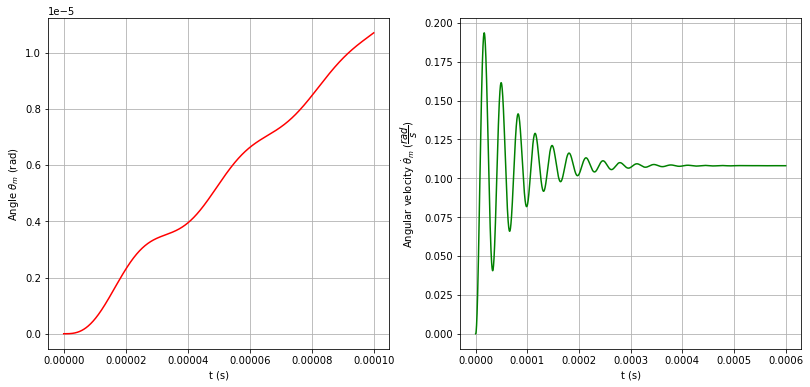

In [138]:
plot_sol(
    [
        {
            "xlabel": "t (s)",
            "ylabel": "Angle $\\theta_m$ (rad)",
            "x": sol_theta.t,
            "graphs": [
                {"y": sol_theta.y[1], "color": "r"},
            ],
        },
        {
            "xlabel": "t (s)",
            "ylabel": "Angular velocity $\\dot \\theta_m$ ($\\dfrac{rad}{s}$)",
            "x": sol.t,
            "graphs": [
                {"y": sol.y[2], "color": "g"},
            ],
        },
    ]
)

1.2

In [139]:
theta_dot = sol.y[2]
theta_dot_nl = theta_dot[-1]
print(f"No load speed (rpm):\n simulated: {theta_dot_nl / rps} \n theoretical: {mdata['no load speed, rpm']}")

No load speed (rpm):
 simulated: 1.032350063694013 
 theoretical: 1267.1090369478832


In [140]:
eps = np.abs(0.01 * theta_dot_nl)
t_const = sol.t[np.abs(theta_dot - theta_dot_nl) >= eps][-1]

In [142]:
print(f"Time constant (ms):\n simulated: {t_const:0.7f} \n theoretical: {L/R:0.7f}")

Time constant (ms):
 simulated: 0.0003146 
 theoretical: 0.0000350


WTF? Почему порядки различаются?

## 2. PD control